In [2]:
import numpy as np
import pandas as pd
from scipy.stats import erlang, expon
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Warmup for mean wait and pct wait


In [112]:
scenario = 63
rep = 4

unit_stop_log = f"./logs/unit_stop_log_scenario_{scenario}_rep_{rep}.csv"

In [113]:
unit_stop_log_df = pd.read_csv(unit_stop_log).sort_values(by=['unit', 'request_entry_ts'])
unit_stop_log_df

,patient_id,patient_type,unit,request_entry_ts,entry_ts,request_exit_ts,exit_ts,planned_los,adjusted_los,entry_tryentry,tryexit_entry,exit_tryexit,exit_enter,exit_tryenter,wait_to_enter,wait_to_exit,bwaited_to_enter,bwaited_to_exit
44,4,2,CSECT,16.814996,16.814996,17.827190,17.827190,1.012195,1.012195,0.0,1.012195,0.0,1.012195,1.012195,0.0,0.0,False,False
104,13,2,CSECT,44.229275,44.229275,44.895452,44.895452,0.666177,0.666177,0.0,0.666177,0.0,0.666177,0.666177,0.0,0.0,False,False
55,19,2,CSECT,60.100171,60.100171,61.045545,61.045545,0.945373,0.945373,0.0,0.945373,0.0,0.945373,0.945373,0.0,0.0,False,False
48,23,2,CSECT,69.487584,69.487584,70.525198,70.525198,1.037614,1.037614,0.0,1.037614,0.0,1.037614,1.037614,0.0,0.0,False,False
162,20,2,CSECT,70.735804,70.735804,71.618446,71.618446,0.882642,0.882642,0.0,0.882642,0.0,0.882642,0.882642,0.0,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66696,20534,2,PP,59914.928671,59914.928671,59979.162975,59979.162975,64.234304,64.234304,0.0,64.234304,0.0,64.234304,64.234304,0.0,0.0,False,False
66686,20539,1,PP,59929.171043,59929.171043,59975.656935,59975.656935,46.485892,46.485892,0.0,46.485892,0.0,46.485892,46.485892,0.0,0.0,False,False
66689,20537,1,PP,59931.030613,59931.030613,59976.570552,59976.570552,45.539939,45.539939,0.0,45.539939,0.0,45.539939,45.539939,0.0,0.0,False,False
66667,20538,1,PP,59936.878306,59936.878306,59951.286734,59951.286734,14.408428,14.408428,0.0,14.408428,0.0,14.408428,14.408428,0.0,0.0,False,False


In [114]:
unit_stop_log_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66708 entries, 44 to 66703
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   patient_id        66708 non-null  int64  
 1   patient_type      66708 non-null  int64  
 2   unit              66708 non-null  object 
 3   request_entry_ts  66708 non-null  float64
 4   entry_ts          66708 non-null  float64
 5   request_exit_ts   66708 non-null  float64
 6   exit_ts           66708 non-null  float64
 7   planned_los       66708 non-null  float64
 8   adjusted_los      66708 non-null  float64
 9   entry_tryentry    66708 non-null  float64
 10  tryexit_entry     66708 non-null  float64
 11  exit_tryexit      66708 non-null  float64
 12  exit_enter        66708 non-null  float64
 13  exit_tryenter     66708 non-null  float64
 14  wait_to_enter     66708 non-null  float64
 15  wait_to_exit      66708 non-null  float64
 16  bwaited_to_enter  66708 non-null  bool 

In [115]:
unit_stop_log_df.groupby(['unit'])['bwaited_to_enter'].mean()

unit
CSECT    0.000000
LDR      0.413185
OBS      0.026147
PP       0.067290
Name: bwaited_to_enter, dtype: float64

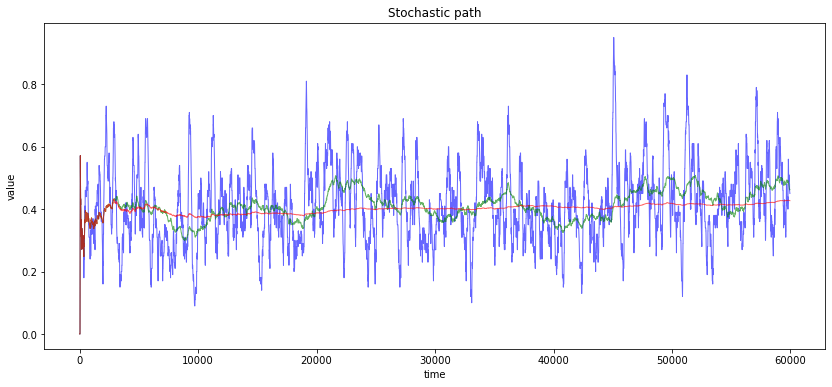

In [123]:
unit = 'LDR'
measure = 'bwaited_to_enter'
x = unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit]['request_entry_ts']
y_raw = unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure]
plot_raw = False
y_ma100 =  unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure].transform(lambda x: x.rolling(100, 1).mean())
y_ma1000 =  unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure].transform(lambda x: x.rolling(1000, 1).mean())
y_ma10000 =  unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure].transform(lambda x: x.rolling(10000, 1).mean())
plt.subplots(figsize=(14, 6))
plt.title("Stochastic path")
plt.xlabel("time")
plt.ylabel("value")

if plot_raw:
    plt.plot(x, y_raw, 'r-', lw=3, alpha=0.6, label='Raw');

plt.plot(x, y_ma100,
       'b-', alpha=0.6, lw=1, label='MA(100)');

plt.plot(x, y_ma1000,
       'g-', alpha=0.6, lw=1, label='MA(1000)');

plt.plot(x, y_ma10000,
       'r-', alpha=0.6, lw=1, label='MA(1000)');

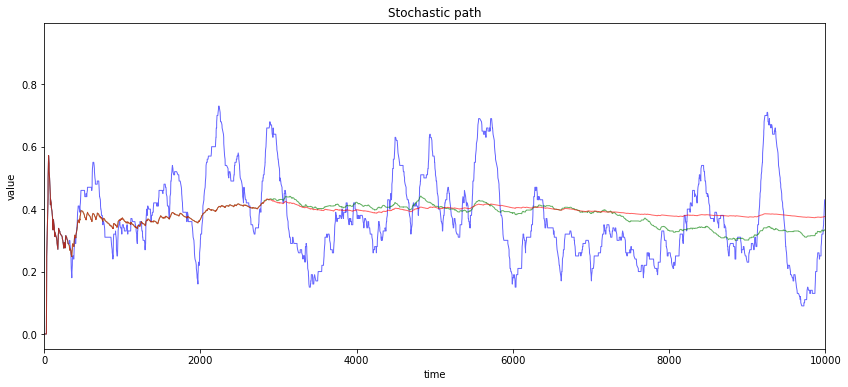

In [124]:
plt.subplots(figsize=(14, 6))
plt.title("Stochastic path")
plt.xlabel("time")
plt.ylabel("value")
plt.xlim(0, 10000)

if plot_raw:
    plt.plot(x, y_raw, 'r-', lw=3, alpha=0.6, label='Raw');

plt.plot(x, y_ma100,
       'b-', alpha=0.6, lw=1, label='MA(100)');

plt.plot(x, y_ma1000,
       'g-', alpha=0.6, lw=1, label='MA(1000)');

plt.plot(x, y_ma10000,
       'r-', alpha=0.6, lw=1, label='MA(10000)');

In [125]:
print(f"w0: {y_raw.mean():.3f}")
print(f"w100: {y_raw[100:].mean():.3f}")
print(f"w500: {y_raw[500:].mean():.3f}")
print(f"w1000: {y_raw[1000:].mean():.3f}")
print(f"w5000: {y_raw[5000:].mean():.3f}")
print(f"w10000: {y_raw[10000:].mean():.3f}")

w0: 0.413
w100: 0.414
w500: 0.415
w1000: 0.413
w5000: 0.421
w10000: 0.424


In [119]:
y_raw.shape

(20538,)

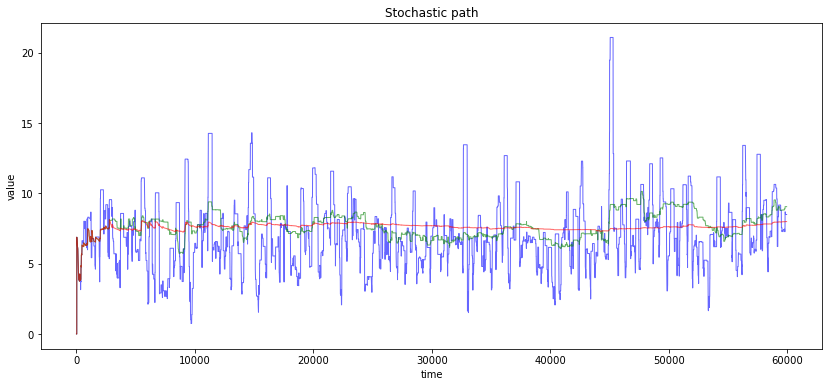

In [126]:
unit = 'LDR'
measure = 'wait_to_enter'
x = unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit]['request_entry_ts']
y_raw = unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure]
plot_raw = False
y_ma100 =  unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure].transform(lambda x: x.rolling(100, 1).quantile(0.95))
y_ma1000 =  unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure].transform(lambda x: x.rolling(1000, 1).quantile(0.95))
y_ma10000 =  unit_stop_log_df.loc[unit_stop_log_df['unit'] == unit][measure].transform(lambda x: x.rolling(10000, 1).quantile(0.95))
plt.subplots(figsize=(14, 6))
plt.title("Stochastic path")
plt.xlabel("time")
plt.ylabel("value")

if plot_raw:
    plt.plot(x, y_raw, 'r-', lw=3, alpha=0.6, label='Raw');

plt.plot(x, y_ma100,
       'b-', alpha=0.6, lw=1, label='MA(100)');

plt.plot(x, y_ma1000,
       'g-', alpha=0.6, lw=1, label='MA(1000)');

plt.plot(x, y_ma10000,
       'r-', alpha=0.6, lw=1, label='MA(1000)');